Starting off, we needed to import the required dependencies for our project. Importing our libraries and prepping the CSV file to be read and interpretted was the first step. One interesting challenge that we encountered early on was the need to break out the dates provided into a useable format for our needs. This involved breaking out the date field that was originally delivered in a YYYY-MM-DD format into three separate columns themselves. 

In [1]:
#import dependencies
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly.express as px
import pandas as pd
import numpy as np

#read csv
csv_path = "../Resources/big_five_stocks.csv"
stock_df = pd.read_csv(csv_path, encoding="utf-8")
#rename the date column to a more useable name
astock = stock_df.rename( columns={'Unnamed: 0':'date'}, inplace=False )
#format the date column to be recognized as a datetime object
astock['Formatted Date'] = pd.to_datetime(astock['date'])
#isolate Year, Month, and Day into separate columns
astock['Month'] = astock['Formatted Date'].map(lambda x: x.month)
astock['Year'] = astock['Formatted Date'].map(lambda x: x.year)
astock['Day'] = astock['Formatted Date'].map(lambda x: x.day)
#Filter down to last 10 years
filterstock = astock[(astock['Year'] >= 2009) & (astock['Year'] <= 2019)]
filterstock.head()

,date,name,open,close,high,low,volume,Formatted Date,Month,Year,Day
26437,2009-01-02,AAPL,12.23,12.96,13.01,12.17,26964210.0,2009-01-02,1,2009,2
26438,2009-01-02,AMZN,51.10,54.36,54.53,51.07,7296667.0,2009-01-02,1,2009,2
26439,2009-01-02,GOOGL,154.01,160.66,160.91,152.75,3617574.0,2009-01-02,1,2009,2
26440,2009-01-02,^IXIC,1578.87,1632.21,1635.83,1572.04,0.0,2009-01-02,1,2009,2
26441,2009-01-02,MSFT,19.54,20.33,20.40,19.37,50121848.0,2009-01-02,1,2009,2


Now that we had the data in the notebook, we needed to isolate the important columns and sort the information appropriately. We decided that we only needed the date related fields we would sort by and the accompanying stock data.

In [2]:
#isolate only useful information
organizedstock = filterstock[['name','Year','Month', 'Day', 'open','close','high','low', 'volume']]
#sort by name and date to organize our stock data chronologically
sortedstock = organizedstock.sort_values(by=['name', 'Year', 'Month', 'Day'])
sortedstock

,name,Year,Month,Day,open,close,high,low,volume
26437,AAPL,2009,1,2,12.23,12.96,13.01,12.17,26964210.0
26446,AAPL,2009,1,5,13.30,13.51,13.74,13.24,42458780.0
26448,AAPL,2009,1,6,13.71,13.29,13.88,13.20,46149128.0
26452,AAPL,2009,1,7,13.09,13.00,13.21,12.89,27042958.0
26458,AAPL,2009,1,8,12.92,13.24,13.31,12.86,24052284.0
...,...,...,...,...,...,...,...,...,...
41630,^IXIC,2019,8,19,8006.18,8002.81,8026.75,7974.36,0.0
41636,^IXIC,2019,8,20,7989.36,7948.56,8010.58,7948.09,0.0
41645,^IXIC,2019,8,21,8017.07,8020.21,8036.94,7998.50,0.0
41651,^IXIC,2019,8,22,8038.79,7991.39,8048.58,7937.13,0.0


The first of the values we decided to gather was the total amount of stock sold by each company over the 10 year period. This was done with a simple for loop in which we used the loc and groupby functions to isolate the volumes and sum them by month.

In [3]:
#For loop to get total sum of vol by month
months = [1,2,3,4,5,6,7,8,9,10,11,12]
for month in months:
    totalvolbymo = sortedstock.loc[sortedstock['Month'] == month].groupby('name')['volume'].sum()
    print(totalvolbymo)

name
AAPL     7.236981e+09
AMZN     1.359727e+09
FB       5.719159e+09
GOOGL    6.494569e+08
MSFT     1.134852e+10
^IXIC    0.000000e+00
Name: volume, dtype: float64
name
AAPL     6.085345e+09
AMZN     1.276771e+09
FB       4.626707e+09
GOOGL    5.584776e+08
MSFT     9.235426e+09
^IXIC    0.000000e+00
Name: volume, dtype: float64
name
AAPL     6.244181e+09
AMZN     1.189071e+09
FB       4.790840e+09
GOOGL    5.962936e+08
MSFT     9.900353e+09
^IXIC    0.000000e+00
Name: volume, dtype: float64
name
AAPL     5.787338e+09
AMZN     1.243370e+09
FB       5.316049e+09
GOOGL    6.113509e+08
MSFT     1.045622e+10
^IXIC    0.000000e+00
Name: volume, dtype: float64
name
AAPL     6.039379e+09
AMZN     1.004306e+09
FB       5.335489e+09
GOOGL    5.096403e+08
MSFT     9.584783e+09
^IXIC    0.000000e+00
Name: volume, dtype: float64
name
AAPL     6.149316e+09
AMZN     9.685126e+08
FB       4.537416e+09
GOOGL    5.212479e+08
MSFT     1.008460e+10
^IXIC    0.000000e+00
Name: volume, dtype: float64
name

The next set of values we needed to isolate were the opening and closing values for each month across each year for each company over the 10 year period. We spent a good amount of time trying to figure out how we were going to approach this. Instead of opting for a nest for loop, we decided to isolate the opening and closing dates by manipulating the original data frame and merging the manipulate dataframe with the original to isolate the values we were after. 

In [4]:
#group by name year and month
groupedstock = sortedstock.groupby(['name','Year','Month'])
#isolate the lowest day available for each month by year and name
firstday = groupedstock['Day'].min()
#isolate the highest day available for each month by year and name
lastday = groupedstock['Day'].max()

In [5]:
#create data frame to house the above values
#create the initial dataframe off the firstday values
summary = pd.DataFrame(firstday)
#add a column to house the lastday values
summary['Last Day'] = lastday
summary.reset_index()

,name,Year,Month,Day,Last Day
0,AAPL,2009,1,2,30
1,AAPL,2009,2,2,27
2,AAPL,2009,3,2,31
3,AAPL,2009,4,1,30
4,AAPL,2009,5,1,29
...,...,...,...,...,...
723,^IXIC,2019,4,1,30
724,^IXIC,2019,5,1,31
725,^IXIC,2019,6,3,28
726,^IXIC,2019,7,1,31


In [6]:
#merge the above dataframe to the original on the opening date to isolate the opening date values for each close date of each month by year and name
mergeddf = pd.merge(summary, sortedstock, on=['name','Year','Month','Day'])
#reorganizing data for readibility
cleandf = mergeddf[['name','Year','Month','Day','Last Day','open']]
#merge the newly create dataframe with the original on the closing date to isolate the closing date values for each close date of each month by year and name
twomerge = pd.merge(cleandf, sortedstock, left_on=["Last Day", 'name','Year','Month'], right_on=["Day", 'name','Year','Month'])
#Reorganizing column names for readibility
cleanmerge = twomerge[['name','Year','Month','Day_x','Last Day','open_x','close']]
#cleaning column names
openclosedf = cleanmerge.rename( columns={'name':'Name', 'Day_x':'First Day', 'open_x':'Open'}, inplace=False )

openclosedf



,Name,Year,Month,First Day,Last Day,Open,close
0,AAPL,2009,1,2,30,12.23,12.88
1,AAPL,2009,2,2,27,12.71,12.76
2,AAPL,2009,3,2,31,12.57,15.02
3,AAPL,2009,4,1,30,14.86,17.98
4,AAPL,2009,5,1,29,17.97,19.40
...,...,...,...,...,...,...,...
723,^IXIC,2019,4,1,30,7800.24,8095.39
724,^IXIC,2019,5,1,31,8132.93,7453.15
725,^IXIC,2019,6,3,28,7441.22,8006.24
726,^IXIC,2019,7,1,31,8145.85,8175.42


In [7]:
# Calculate percent change
openclosedf['Percent Change (%)'] = round(((openclosedf['close']-openclosedf['Open'])/openclosedf['Open'])*100,2)
openclosedf['Date'] = pd.to_datetime(openclosedf[['Year', 'Month']].assign(DAY=1))

# create data frames for each ticker name
AAPL_df = openclosedf.loc[openclosedf['Name'] ==  'AAPL']
AMZN_df = openclosedf.loc[openclosedf['Name'] ==  'AMZN']
FB_df = openclosedf.loc[openclosedf['Name'] ==  'FB']
GOOGL_df = openclosedf.loc[openclosedf['Name'] ==  'GOOGL']
MSFT_df = openclosedf.loc[openclosedf['Name'] ==  'MSFT']
IXIC_df = openclosedf.loc[openclosedf['Name'] ==  '^IXIC']


In [8]:
AAPL_df

,Name,Year,Month,First Day,Last Day,Open,close,Percent Change (%),Date
0,AAPL,2009,1,2,30,12.23,12.88,5.31,2009-01-01
1,AAPL,2009,2,2,27,12.71,12.76,0.39,2009-02-01
2,AAPL,2009,3,2,31,12.57,15.02,19.49,2009-03-01
3,AAPL,2009,4,1,30,14.86,17.98,21.00,2009-04-01
4,AAPL,2009,5,1,29,17.97,19.40,7.96,2009-05-01
...,...,...,...,...,...,...,...,...,...
123,AAPL,2019,4,1,30,191.64,200.67,4.71,2019-04-01
124,AAPL,2019,5,1,31,209.88,175.07,-16.59,2019-05-01
125,AAPL,2019,6,3,28,175.60,197.92,12.71,2019-06-01
126,AAPL,2019,7,1,31,203.17,213.04,4.86,2019-07-01


<IPython.core.display.Javascript object>


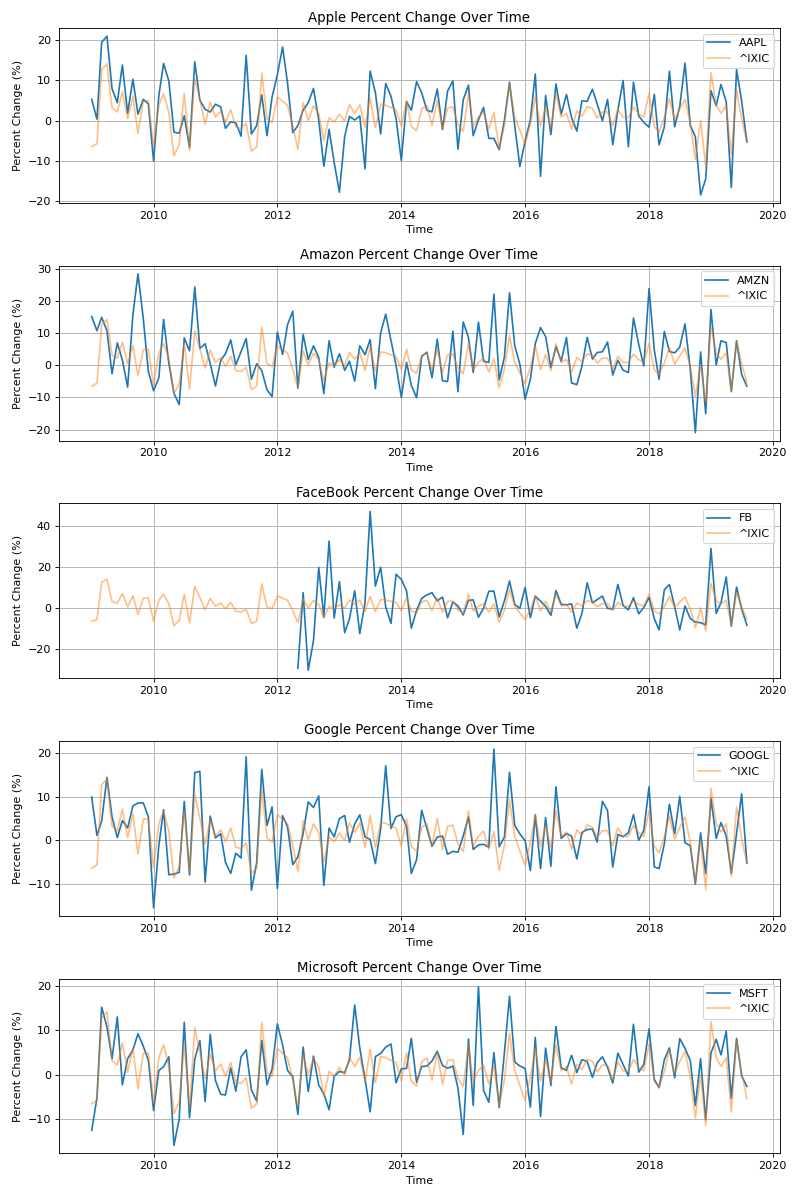

In [11]:
# create 5 subplots comparing each stock to the NASDAQ index
fig, ax = plt.subplots(5)
ax1 = ax[0]
ax2 = ax[1]
ax3 = ax[2]
ax4 = ax[3]
ax5 = ax[4]
fig.set_figwidth(10)
fig.set_figheight(15)

# plot each stock to a subplot
ax1.plot(AAPL_df['Date'], AAPL_df['Percent Change (%)'],label = "AAPL" )
ax2.plot(AMZN_df['Date'], AMZN_df['Percent Change (%)'],label = "AMZN")
ax3.plot(FB_df['Date'], FB_df['Percent Change (%)'],label = "FB")
ax4.plot(GOOGL_df['Date'], GOOGL_df['Percent Change (%)'],label = "GOOGL")
ax5.plot(MSFT_df['Date'], MSFT_df['Percent Change (%)'],label = "MSFT")

# plot the NASDAQ index to each subplot
ax1.plot(IXIC_df['Date'], IXIC_df['Percent Change (%)'], label="^IXIC", alpha=0.5)
ax2.plot(IXIC_df['Date'], IXIC_df['Percent Change (%)'], label="^IXIC", alpha=0.5)
ax3.plot(IXIC_df['Date'], IXIC_df['Percent Change (%)'], label="^IXIC", alpha=0.5)
ax4.plot(IXIC_df['Date'], IXIC_df['Percent Change (%)'], label="^IXIC", alpha=0.5)
ax5.plot(IXIC_df['Date'], IXIC_df['Percent Change (%)'], label="^IXIC", alpha=0.5)

# add labels and title for each subplot
ax1.set(xlabel='Time', ylabel='Percent Change (%)',
       title='Apple Percent Change Over Time')
ax1.grid()


ax2.set(xlabel='Time', ylabel='Percent Change (%)',
       title='Amazon Percent Change Over Time')
ax2.grid()


ax3.set(xlabel='Time', ylabel='Percent Change (%)',
       title='FaceBook Percent Change Over Time')
ax3.grid()


ax4.set(xlabel='Time', ylabel='Percent Change (%)',
       title='Google Percent Change Over Time')
ax4.grid()


ax5.set(xlabel='Time', ylabel='Percent Change (%)',
       title='Microsoft Percent Change Over Time')
ax5.grid()

# add legend to each subplot
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
ax3.legend(loc="upper right")
ax4.legend(loc="upper right")
ax5.legend(loc="upper right")

plt.tight_layout()

plt.show()
plt.savefig('pct_changeV1.1.png')

In [19]:
################ NOTE ##################
# install modelules/ libraries if needed
#install one at a time, not needed after installation


# pip install cufflinks
# pip install plotly




#install the folling in Conda
# conda install -c plotly plotly-orca

In [24]:
#dependencies 
import os
import plotly.express as px
from plotly.offline import iplot
import plotly.graph_objects as go


# dataframe of a wide format
openclosedf['Date']=openclosedf.index

#setting colors and
colors = px.colors.qualitative.Plotly
fig = go.Figure()

# setting x and Y Axis
x_aapl = AAPL_df['Date']
y_aapl = AAPL_df['Percent Change (%)']

x_amzn = AMZN_df['Date']
y_amzn =AMZN_df['Percent Change (%)']

x_fb = FB_df['Date']
y_fb = FB_df['Percent Change (%)']

x_goog = GOOGL_df['Date']
y_goog = GOOGL_df['Percent Change (%)']

x_msft = MSFT_df['Date']
y_msft =MSFT_df['Percent Change (%)']

x_ixic = IXIC_df['Date']
y_ixic = IXIC_df['Percent Change (%)']


#plotting
fig.add_traces(go.Scatter(x=x_aapl, y = y_aapl, mode = 'lines', name = 'AAPL', line=dict(color=colors[0])))
fig.add_traces(go.Scatter(x=x_amzn, y =y_amzn , mode = 'lines', name = 'AMZN', line=dict(color=colors[1])))
fig.add_traces(go.Scatter(x=x_fb, y =y_fb , mode = 'lines', name = 'FB', line=dict(color=colors[2])))
fig.add_traces(go.Scatter(x=x_goog, y =y_goog , mode = 'lines', name = 'GOOGL', line=dict(color=colors[3])))
fig.add_traces(go.Scatter(x=x_msft, y =y_msft, mode = 'lines', name = 'MSFT', line=dict(color=colors[4])))
fig.add_traces(go.Scatter(x=x_ixic, y = y_ixic, mode = 'lines', name = 'IXIC', line=dict(color=colors[5])))

#Labeling the Plot
fig.update_layout(title="Percent Over time (Interactive Plot)",
                  xaxis_title='Date',
                  yaxis_title='Percent Change (%)',
                  legend_title="Legend Title",
                  font=dict(family="Aerial",
                            size=13,
                            color="Black")
                  )

# Zoom Slider
fig.update_xaxes(
    rangeslider_visible=True,
    tickformatstops = [
        dict(dtickrange=[None, 1000], value="%H:%M:%S.%L ms"),
        dict(dtickrange=[1000, 60000], value="%H:%M:%S s"),
        dict(dtickrange=[60000, 3600000], value="%H:%M m"),
        dict(dtickrange=[3600000, 86400000], value="%H:%M h"),
        dict(dtickrange=[86400000, 604800000], value="%e. %b d"),
        dict(dtickrange=[604800000, "M1"], value="%e. %b w"),
        dict(dtickrange=["M1", "M12"], value="%b '%y M"),
        dict(dtickrange=["M12", None], value="%Y Y")
    ]
)


#printing
fig.show()

#Outputting the image and saving the image to an external file as a png
if not os.path.exists("images"):
    os.mkdir("images")
    
fig.write_image("images/fig1.png")

In [ ]:
# pie plot interactive plot: 
#  --> https://plotly.com/python/pie-charts/




In [ ]:
pie plots:
    volume totals

max min summeries

linear reg (percent change over time)